### Getting Started with Airflow

Programmatically Author, Schedule and Monitor workflows.  
Benefits:-
- Atomic
- Scalability
- UI
- Extensibility  

**Core Components**
- Web Server: Flast server with Gunicorn serving the UI. communicates with the 'Metastore', and 'Scheduler' & 'Executor' also communicates with 'Metastore'
- Scheduler: Daemon in charge of scheduling workflows
- Metastore
- Triggerer
- Executor: doesn't execute a task, but it defines how and on which system your tasks are executed. Sends tasks to execute to the 'Queue'
- Queue: to execute tasks in the correct order
- Worker

**Operator** -> A way to encapsulate what we want to do
> db= connect(host, credentials)  
> db.insert(sql_request)
- Action Operators : executes something, ex- PythonOperator executes a Python function, bash Operator executes bash commands
- Transfer Operators : allow to transfer data from a point A to B, ex- MySQL to RedShift
- Sensor Operators : allow to wait for something before moving to next task

**Tasks** -> Operator is a task and when we run an operator, which is a "task" we get a task instance

**Architecture**
- Single Node Architecture = Node(Web Server + Metastore + Scheduler + Executor + Queue)
- Multi Node Architecture = 
  - Case Celery Executore and have RabbitMQ/Redis
    - Node 1: Web Server + Scheduler & Executor
    - Node 2: Metastore + Queue
    - 3/Many additional Worker Node

**How does it works?**
- Create a new DAG, dag.py and put that file into the folder "dag"
- Scheduler process this folder ***dag*** every 5 mintues, by default to detect new DAGs.
- Whenever we apply a modification to that DAG we may ned to wait up to 30 seconds before getting modification.
  Adding new DAG Scheduler process every 5 minutes for new DAG and 30 seconds for existing DAG 
- Scheduler run the DAG and for that it creates a ***DagRun Object*** with the state=running
- Then it takes the first task to execute and that tasks becomes a task instance object, it has the state=None and then Scheduled
- After that the Scheduler sends the task instance object to the Queue of the Executor 
- Now the state of the task is Queued and the Executor creates a sub process to run the task, and now the task instance object has the state Running.
- Once the task is Done, the state of the task is Success/Failed
- if DAG is done then DAG Run has the state success.

**Key Takeaways**
- Airflow is an orchestrator, not a processing framework. Process GB of data outside of Airflow(i.e Have a Spark cluster, use an operator to execute a Spark Job and data is processed in Spark)
- A DAG is a data pipeline, an Operator is a task
- An executor defines how tasks are executed, whereas a worker is a process executing the tasks
- The Scheduler schedules our tasks, the web server serves the UI, and the database stores the metadata of Airflow.

**Providers** - https://registry.astronomer.io/  
- Airflow Core : pip install apache-airflow
- Snowflake : pip install apache-airflow-providers-snowflake
- AWS : pip install apache-airflow-providers-amazon
- Databricks : pip install apache-airflow-providers-databricks
- Dbt : pip install apache-airflow-providers-dbt-cloud

**DAG Scheduling**  
- start_date: The timestamp from which the scheduler will attempt to backfill
- schedule_interval: How often a DAG runs
- end_date: The timestamp from which a DAG ends

### The New Way of Scheduling DAGs - DataSet

**What is a Dataset?**
A logical grouping of data, like a file, like a square table. Anything that has data, it has 2 properties:  
- URI : the path to data/data file OR 
  - unique identifier of our data
  - Path to data
  - must composed of only ASCII characters
  - The URI scheme can not be airflow
  - case sensitive
  - ex :
  `from airflow import Dataset`  
  `# valid datasets:`  
  `schemaless = Dataset("/path/file.txt")  `  
  `csv_file = Dataset("file.csv", extra={'owner': 'Raj'})`  
  `#invalid datasets:  `  
  `reserved = Dataset("airflow://file.txt")`  
  `not_ascii = Dataset("file_dataset")`  
  `
- EXTRA : dictionary that we can define as {'owner' : 'owner of table is rshukla}, to attach additional information to our data set.

**Dataset Limitations**  Dataset are amazing, but they have limitations as well:  
- DAGs can only use Datasets in the same Airflow instance. A DAG cannot wait for a Dataset defined in another Airflow instance
- Consumer DAGs are triggered every time a task that updates datasets completes successfuly. ***Airflow doesn't check whether the data has been effectively updated***
- You can't combine diff schedules like datasets with cron expressions.
- If two tasks update the same dataset, as soon as one is done, that triggers the Consumer DAG immediately without waiting for the second task to complete.
- Airflow monitors datasets only within the context of DAGs and Tasks. if an external tool updates the actual data represented by a Dataset, Airflow has no way of knowing that

In [ ]:
from airflow import DAG, Dataset
from airflow.decorators import task

from datetime import date, datetime

my_file = Dataset("/tmp/my_file.txt")
my_file_2 = Dataset("/tmp/my_file_2.txt")

with DAG(dag_id="producer", schedule="@daily", start_date=datetime(2023,11,20), catchup=False):

    @task(outlets=[my_file])
    def update_dataset():
        with open(my_file.uri, "a+") as f:
            f.write("producer update")

    @task(outlets=[my_file_2])
    def update_dataset_2():
        with open(my_file_2.uri, "a+") as f:
            f.write("producer update")            

    update_dataset() >> update_dataset_2()

In [ ]:
from airflow import DAG, Dataset
from airflow.decorators import task
from datetime import date, datetime

my_file=Dataset("/tmp/my_file.txt")
my_file_2=Dataset("/tmp/my_file_2.txt")

with DAG(dag_id="consumer", schedule=[my_file, my_file_2], start_date=datetime(2023,11,20), catchup=False):
    
    @task
    def read_dataset():
        with open(my_file.uri, "r") as f:
            print(f.read())

    read_dataset()

#### Databases and Executors

**What's an executor?** It doesn't run our tasks, it doesn't execute our tasks. It defines how to run our tasks on which system, may diff executors we have that we can use:  
- local executors : to run multiple tasks on a single machine
  - sequential executor : to run one task at a time on a single machine
- remote executors
  - celery executor
  - kubernetes executor  

To change the executor, change executor parameter in the configuration file of airflow.  
file->docker-compose.yml  
`environment:  `  
`  &airflow-common-env`.   
`  AIRFLOW__CORE__EXECUTOR: CeleryExecutor  -> will override the setting defined `  
  
`file->airflow.cfg`  
`executor = SequentialExecutor  `  

***So as we use docker, we need to modify the configuration of airflow***

**The Sequential Executor** By default when we install airflow manually, there are 3 components:
- Web Server
- Scheduler
- SQLite

**The Local Executor** One setp further than the sequential executor, as it allows to execute multiple tasks at the same time, but on a single machine and with diff database
- Web Server
- Scheduler
- Postgres/MySQL/Oracle DB  
to configure it  
`executor=LocalExecutor`  
`sql_alchemy_conn=postgresql+psycopg2://<user>:<password>@<host>/<db>`

**The Celery Executor**
- Web Server
- Scheduler
- Postgres/MySQL/Oracle DB  (metadata)
- Celery Queue = Result backend(status of the tasks that have been executed) + Broker/Queue(could be Redis/RabbitMQ need to install, and coz of it 2 additional config need to define)
- Many workers : to execute our tasks  
to configure it  
`executor=CeleryExecutor`  
`sql_alchemy_conn=postgresql+psycopg2://<user>:<password>@<host>/<db>`  
`celery_result_backend=postgresql+psycopg2://<user>:<password>@<host>/<db>`  
`celery_broker_url=redis://:@redis:6379/0`

**Config**
- `airflow celery worker` executing this command on a given machine becomes a airflow worker where we can execute tasks
- `docker cp growthair_airflow-scheduler_1:/opt/airflow/airflow.cfg .` to copy airflow configuration file to local
- `docker-compose down && docker-compose --profile flower up -d` to start airflow flower
- `https://stunning-fortnight-7xqxvp6pvr7fx594-5555.app.github.dev/` port 5555 to see number of celery/other workers and their info
- AIRFLOW__CORE__LOAD_EXAMPLES=false to disable default DAGs example visibility

**What is a Queue?**  
CELERY = [Result Backend + Queue] => Queue(high_cpu | ml_model | default) =>where (high_cpu=Worker(5cpu) | ml_model=Worker(GPU) | default=Worker(1 cpu))

**Add a new celery Worker**
- docker-compose.yml -> services: -> copy & paste with 'airflow-worker' section and rename it as 'airflow-worker-2' & restart instance(`docker-compose down && docker-compose --profile flower up -d`), we will see 2 worker in 'flower' UI 5555  
***OR***
- if have multiple machine then on every machine run- `airflow celery worker` to consider that machine as airflow worker

**Create a queue to better distribute tasks**
- `airflow celery worker -q high_cpu` -> will create a new queue 'high_cpu' and will see it in flower and will be able to send the tasks only this specific worker using this queue high_cpu in docker-compose.yml section airflow-worker-2 in my case
- by default when we execute a task, that task is sent to the default queue as defined in configuration using parameter *default_queue* in airflow.cfg 

**Concurrency** Defines the number of tasks and DAG Runs that we can execute at the same time(in parallel), Airflow has several parameters to tune tasks and DAGs concurrency  
- parallelism/AIRFLOW__CORE__PARALLELISM: The MAX number of task instances can in Airflow per Scheduler. By default = 32 tasks at the same time, if 2 schedulers then 2 x 32 = 64 tasks
- max_active_tasks_per_dag/AIRFLOW__CORE__MAX_ACTIVE_TASKS_PER_DAG: MAX number of task instances allowed to run concurrently in each DAG, by default 16 at the same time for a given DAG across all DAG run
- max_active_runs_per_dag/AIRFLOW__CORE__MAX_ACTIVE_RUNS_PER_DAG: defines the MAX number of active DAG runs per DAG. By default can have up to 16 DAG runs per DAG running at the same time

Resolved using following steps:

If you want to run docker as non-root user then you need to add it to the docker group.

Create the docker group if it does not exist: $ sudo groupadd docker

Add your user to the docker group: $ sudo usermod -aG docker $USER

Run the following command or Logout and login again and run (that doesn't work you may need to reboot your machine first) : $ newgrp docker

Check if docker can be run without root: $ docker run hello-world

Reboot if still got error: $ reboot

Stop VM and restart and it will work!

#### Apache Airflow: The Hands-On Guide

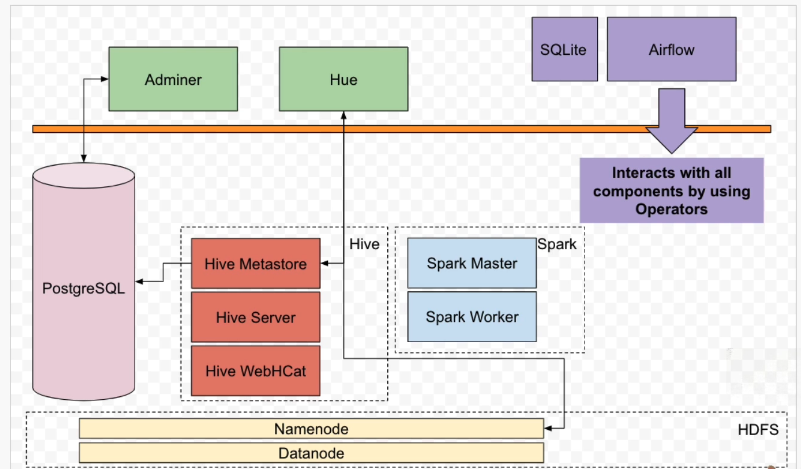

In [1]:
from IPython.display import Image
Image(filename='/workspaces/codespaces-jupyter/images/ForexDataPipelineArch.png') 